In [180]:
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from caveclient import CAVEclient

# Setup Caveclient

In [8]:
# load minnie65_public dataset and set materialization version to timestamp 4/29/2025
client = CAVEclient("minnie65_public")
client.version = 1412

In [9]:
client.materialize.tables

['aibs_column_nonneuronal_ref', 'aibs_metamodel_celltypes_v661', 'aibs_metamodel_mtypes_v661_v2', 'allen_column_mtypes_v2', 'allen_v1_column_types_slanted_ref', 'apl_functional_coreg_vess_fwd', 'baylor_gnn_cell_type_fine_model_v2', 'baylor_log_reg_cell_type_coarse_v1', 'bodor_pt_cells', 'bodor_pt_target_proofread', 'cg_cell_type_calls', 'coregistration_auto_phase3_fwd_apl_vess_combined_v2', 'coregistration_auto_phase3_fwd_v2', 'coregistration_manual_v4', 'functional_properties_v3_bcm', 'gamlin_2023_mcs', 'gamlin_2023_mcs_met_types', 'l5et_column', 'multi_input_spine_predictions_ssa', 'nucleus_alternative_points', 'nucleus_detection_v0', 'nucleus_functional_area_assignment', 'nucleus_ref_neuron_svm', 'proofreading_status_and_strategy', 'pt_synapse_targets', 'synapse_target_predictions_ssa', 'synapse_target_structure', 'synapses_pni_2', 'vortex_astrocyte_proofreading_status', 'vortex_compartment_targets', 'vortex_manual_myelination_v0', 'vortex_manual_nodes_of_ranvier', 'vortex_thalamic_proofreading_status']

# Visualize location of proofread cells

In [ ]:
proof_pos_df = client.materialize.tables.proofreading_status_and_strategy(status_axon="t") \
    .query(desired_resolution=[1000,1000,1000], split_positions=True,
           select_columns=["pt_root_id","pt_position"])
proof_pos_df.drop_duplicates(subset="pt_root_id", inplace=True)

area_df = client.materialize.tables.nucleus_functional_area_assignment() \
    .query(desired_resolution=[1000,1000,1000], 
           select_columns={"nucleus_detection_v0": ["pt_root_id"],
                           "nucleus_functional_area_assignment": ["tag"]})
area_df.drop_duplicates(subset="pt_root_id", inplace=True)

prop_df = client.materialize.tables.functional_properties_v3_bcm() \
    .query(desired_resolution=[1000,1000,1000],
           select_columns={"nucleus_detection_v0": ["pt_root_id"],
                           "functional_properties_v3_bcm": ["pref_ori","pref_dir","gOSI","gDSI"]})
prop_df.drop_duplicates(subset="pt_root_id", inplace=True)

taxon_df = client.materialize.tables.vortex_thalamic_proofreading_status() \
    .query(desired_resolution=[1000,1000,1000], split_positions=True,
           select_columns=["pt_root_id","pt_position"])

proof_pos_df = proof_pos_df.merge(area_df, on="pt_root_id", how="left") \
    .merge(prop_df, on="pt_root_id", how="left")
proof_pos_df.loc[proof_pos_df["pt_root_id"].isin(taxon_df["pt_root_id"]), "tag"] = "TH"
print(proof_pos_df.groupby("tag").size())
proof_pos_df.head()

tag
AL      57
RL     145
TH      20
V1    1760
dtype: int64


,pt_root_id,pt_position_x,pt_position_y,pt_position_z,tag,pref_ori,pref_dir,gOSI,gDSI
0,864691135308929350,736.768,1035.584,937.36,V1,NaN,NaN,NaN,NaN
1,864691135163673901,726.208,754.048,816.88,V1,NaN,NaN,NaN,NaN
2,864691136812081779,1329.476,475.260,700.72,AL,3.113942,3.113942,0.141621,0.115765
3,864691136090326071,768.320,760.256,891.88,V1,NaN,NaN,NaN,NaN
4,864691136195284556,692.736,869.888,877.16,V1,NaN,NaN,NaN,NaN


In [202]:
with open ("proof_pos_df.pkl","wb") as f:
    pickle.dump(proof_pos_df, f)

Text(0, 0.5, 'Depth position (μm)')

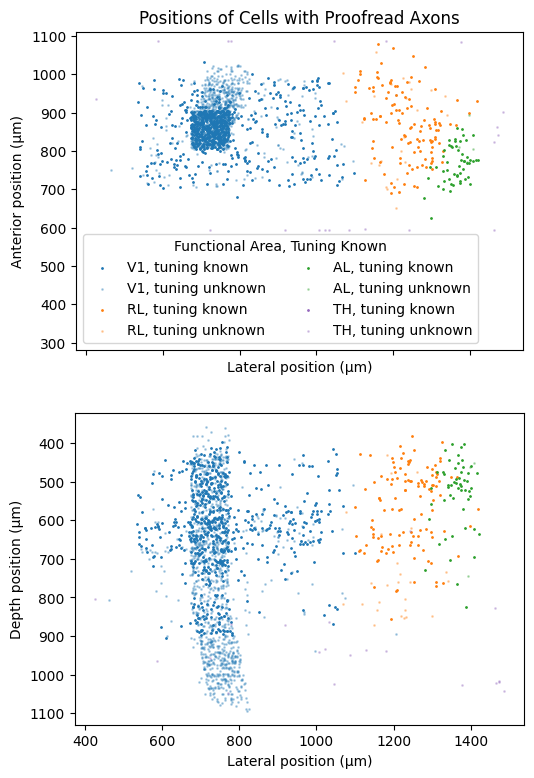

In [161]:
fig,axs = plt.subplots(2,1, figsize=(6,9), sharex=True, gridspec_kw={"height_ratios": [1.02, 1]})

V1_mask = proof_pos_df.tag == "V1"
RL_mask = proof_pos_df.tag == "RL"
AL_mask = proof_pos_df.tag == "AL"
TH_mask = proof_pos_df.tag == "TH"

prop_mask = proof_pos_df.pref_ori.notna()

for label,mask,color in zip(["V1","RL","AL","TH"], [V1_mask,RL_mask,AL_mask,TH_mask], ["C0","C1","C2","C4"]):
    axs[0].scatter(proof_pos_df[mask & prop_mask].pt_position_x.values,
                   proof_pos_df[mask & prop_mask].pt_position_z.values,
                   color=color, s=1, label=label+", tuning known")
    axs[0].scatter(proof_pos_df[mask & ~prop_mask].pt_position_x.values,
                   proof_pos_df[mask & ~prop_mask].pt_position_z.values,
                   color=color, s=1, alpha=0.3, label=label+", tuning unknown")
    axs[1].scatter(proof_pos_df[mask & prop_mask].pt_position_x.values,
                   proof_pos_df[mask & prop_mask].pt_position_y.values,
                   color=color, s=1, label=label+", tuning known")
    axs[1].scatter(proof_pos_df[mask & ~prop_mask].pt_position_x.values,
                   proof_pos_df[mask & ~prop_mask].pt_position_y.values,
                   color=color, s=1, alpha=0.3, label=label+", tuning unknown")
    
axs[0].set_ylim(0.8*(np.max(proof_pos_df.pt_position_z.values) \
    - (np.max(proof_pos_df.pt_position_y.values) - np.min(proof_pos_df.pt_position_y.values))),None)
axs[0].legend(title="Functional Area, Tuning Known",ncols=2)

axs[0].set_aspect("equal")
axs[0].set_xlabel("Lateral position (μm)")
axs[0].set_ylabel("Anterior position (μm)")
axs[0].set_title("Positions of Cells with Proofread Axons")

axs[1].invert_yaxis()
axs[1].set_aspect("equal")
axs[1].set_xlabel("Lateral position (μm)")
axs[1].set_ylabel("Depth position (μm)")

# Visualize location of functionally recorded cells

In [184]:
func_pos_df = client.materialize.tables.coregistration_manual_v4() \
    .query(desired_resolution=[1000,1000,1000], split_positions=True,
           select_columns={"nucleus_detection_v0": ["pt_root_id","pt_position"]})#,
                        #    "coregistration_manual_v4": ["session","scan_idx","unit_id","field"]})

area_df = client.materialize.tables.nucleus_functional_area_assignment() \
    .query(desired_resolution=[1000,1000,1000], 
           select_columns={"nucleus_detection_v0": ["pt_root_id"],
                           "nucleus_functional_area_assignment": ["tag"]})
area_df.drop_duplicates(subset="pt_root_id", inplace=True)

func_prop_df = client.materialize.tables.functional_properties_v3_bcm() \
    .query(desired_resolution=[1000,1000,1000],
           select_columns={"nucleus_detection_v0": ["pt_root_id"],
                           "functional_properties_v3_bcm": ["pref_ori","pref_dir","gOSI","gDSI"]})
func_prop_df.drop_duplicates(subset="pt_root_id", inplace=True)

func_pos_df = func_pos_df.merge(area_df, on="pt_root_id", how="left") \
    .merge(func_prop_df, on="pt_root_id", how="left")
func_pos_df["has_tuning"] = func_pos_df.pref_ori.notna()
func_pos_df.head()

,pt_root_id,pt_position_x,pt_position_y,pt_position_z,tag,pref_ori,pref_dir,gOSI,gDSI,has_tuning
0,864691135702330235,843.136,728.128,906.92,V1,1.648632,1.648632,0.063371,0.047185,True
1,864691135614842827,545.600,682.560,718.04,V1,NaN,NaN,NaN,NaN,False
2,864691135614842827,545.600,682.560,718.04,V1,NaN,NaN,NaN,NaN,False
3,864691136966116814,1243.776,463.552,670.08,AL,NaN,NaN,NaN,NaN,False
4,864691135430194992,757.888,477.184,1041.48,V1,1.407509,4.549102,0.090610,0.101717,True


In [158]:
func_pos_df.groupby(["tag","has_tuning"]).size()

tag  has_tuning
AL   False          340
     True           885
LM   False            3
     True            28
RL   False         1420
     True          3324
V1   False         3930
     True          9251
dtype: int64

In [203]:
with open ("func_pos_df.pkl","wb") as f:
    pickle.dump(func_pos_df, f)

Text(0, 0.5, 'Depth position (μm)')

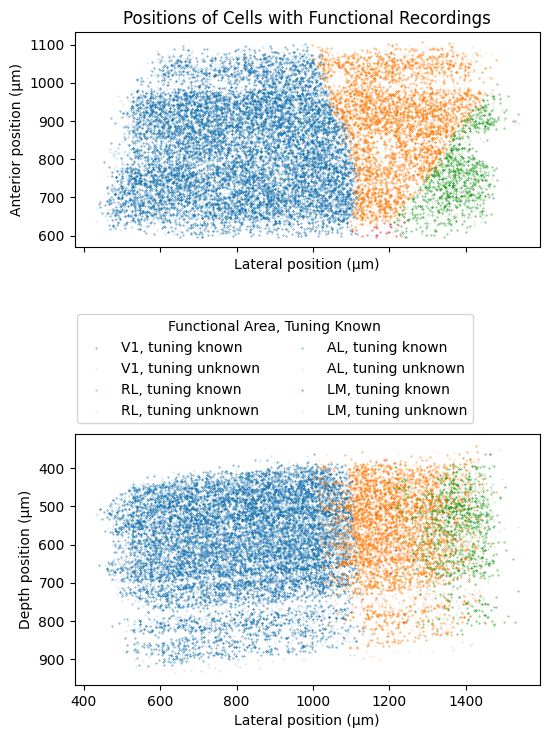

In [173]:
fig,axs = plt.subplots(2,1, figsize=(6,10), sharex=True, gridspec_kw={"height_ratios": [1.01, 1]})

V1_mask = func_pos_df.tag == "V1"
RL_mask = func_pos_df.tag == "RL"
AL_mask = func_pos_df.tag == "AL"
LM_mask = func_pos_df.tag == "LM"

prop_mask = func_pos_df.pref_ori.notna()

for label,mask,color in zip(["V1","RL","AL","LM"], [V1_mask,RL_mask,AL_mask,LM_mask], ["C0","C1","C2","C3"]):
    axs[0].scatter(func_pos_df[mask & prop_mask].pt_position_x.values,
                   func_pos_df[mask & prop_mask].pt_position_z.values,
                   color=color, s=0.1, label=label+", tuning known")
    axs[0].scatter(func_pos_df[mask & ~prop_mask].pt_position_x.values,
                   func_pos_df[mask & ~prop_mask].pt_position_z.values,
                   color=color, s=0.1, alpha=0.3, label=label+", tuning unknown")
    axs[1].scatter(func_pos_df[mask & prop_mask].pt_position_x.values,
                   func_pos_df[mask & prop_mask].pt_position_y.values,
                   color=color, s=0.1)
    axs[1].scatter(func_pos_df[mask & ~prop_mask].pt_position_x.values,
                   func_pos_df[mask & ~prop_mask].pt_position_y.values,
                   color=color, s=0.1, alpha=0.3)
    
# axs[1].set_ylim(0.8*(np.max(func_pos_df.pt_position_y.values) \
#     - (np.max(func_pos_df.pt_position_z.values) - np.min(func_pos_df.pt_position_z.values))),None)
fig.legend(title="Functional Area, Tuning Known",ncols=2,loc="outside center")

axs[0].set_aspect("equal")
axs[0].set_xlabel("Lateral position (μm)")
axs[0].set_ylabel("Anterior position (μm)")
axs[0].set_title("Positions of Cells with Functional Recordings")

axs[1].invert_yaxis()
axs[1].set_aspect("equal")
axs[1].set_xlabel("Lateral position (μm)")
axs[1].set_ylabel("Depth position (μm)")

# Merge cell type, area, functional preference, and proofreading data

In [192]:
proof_df = client.materialize.tables.proofreading_status_and_strategy(status_axon="t") \
    .query(desired_resolution=[1000,1000,1000], split_positions=True,
           select_columns=["pt_root_id","pt_position"])

area_df = client.materialize.tables.nucleus_functional_area_assignment() \
    .query(desired_resolution=[1000,1000,1000], 
           select_columns={"nucleus_detection_v0": ["pt_root_id"],
                           "nucleus_functional_area_assignment": ["tag"]})
area_df.drop_duplicates(subset="pt_root_id", inplace=True)

type_df = client.materialize.tables.aibs_metamodel_mtypes_v661_v2() \
    .query(desired_resolution=[1000,1000,1000],
           select_columns={"nucleus_detection_v0": ["pt_root_id"],
                           "aibs_metamodel_mtypes_v661_v2": ["cell_type"]})
type_df.drop_duplicates(subset="pt_root_id", inplace=True)

func_df = client.materialize.tables.coregistration_manual_v4() \
    .query(desired_resolution=[1000,1000,1000], split_positions=True,
           select_columns={"nucleus_detection_v0": ["pt_root_id","pt_position"]})[["pt_root_id"]]
func_df.drop_duplicates(subset="pt_root_id", inplace=True)

prop_df = client.materialize.tables.functional_properties_v3_bcm() \
    .query(desired_resolution=[1000,1000,1000],
           select_columns={"nucleus_detection_v0": ["pt_root_id"],
                           "functional_properties_v3_bcm": ["pref_ori","pref_dir","gOSI","gDSI"]})
prop_df.drop_duplicates(subset="pt_root_id", inplace=True)

taxon_df = client.materialize.tables.vortex_thalamic_proofreading_status() \
    .query(desired_resolution=[1000,1000,1000], split_positions=True,
           select_columns=["pt_root_id","pt_position"])

column_df = client.materialize.tables.allen_column_mtypes_v2() \
    .query(desired_resolution=[1000,1000,1000])[["pt_root_id"]]
    
comb_df = proof_df.merge(area_df, on="pt_root_id", how="left") \
    .merge(type_df, on="pt_root_id", how="left") \
    .merge(prop_df, on="pt_root_id", how="left")
comb_df.loc[comb_df["pt_root_id"].isin(taxon_df["pt_root_id"]), "tag"] = "TH"
comb_df["in_column"] = comb_df.pt_root_id.isin(column_df.pt_root_id)
comb_df["has_function"] = comb_df.pt_root_id.isin(func_df.pt_root_id)
comb_df.head()

,pt_root_id,pt_position_x,pt_position_y,pt_position_z,tag,cell_type,pref_ori,pref_dir,gOSI,gDSI,in_column,has_function
0,864691135308929350,736.768,1035.584,937.36,V1,L6tall-c,NaN,NaN,NaN,NaN,True,False
1,864691135163673901,726.208,754.048,816.88,V1,L5b,NaN,NaN,NaN,NaN,True,False
2,864691136812081779,1329.476,475.260,700.72,AL,L3a,3.113942,3.113942,0.141621,0.115765,False,True
3,864691136090326071,768.320,760.256,891.88,V1,L5b,NaN,NaN,NaN,NaN,True,False
4,864691136195284556,692.736,869.888,877.16,V1,DTC,NaN,NaN,NaN,NaN,True,False


In [204]:
with open ("comb_df.pkl","wb") as f:
    pickle.dump(comb_df, f)

In [179]:
comb_df.groupby(["tag","cell_type"]).size().to_frame()

0
tag cell_type     
AL  DTC          1
    L2a          5
    L2c          4
    L3a         51
    L3b          9
    L4a          3
    L4b          1
    L4c          2
    L5ET         2
    L5a          6
    L6tall-a     1
RL  DTC          5
    L2a         11
    L2b          3
    L2c         18
    L3a         56
    L3b         22
    L4a         19
    L4b         11
    L4c          9
    L5ET        15
    L5a         22
    L5b          2
    L6short-a    3
    L6tall-a     2
    PTC          5
V1  DTC         69
    ITC         26
    L2a         76
    L2b         77
    L2c        116
    L3a         95
    L3b        180
    L4a        161
    L4b        273
    L4c        110
    L5ET        52
    L5NP        13
    L5a         46
    L5b         55
    L6short-a   79
    L6short-b   56
    L6tall-a    95
    L6tall-b    52
    L6tall-c   112
    PTC         82
    STC          8

In [193]:
comb_df.groupby(["in_column","has_function","tag"]).size().to_frame()

0
in_column has_function tag     
False     False        AL     2
                       RL    17
                       TH    20
                       V1    55
          True         AL    55
                       RL   128
                       V1   355
True      False        V1   861
          True         V1   489

# Generate connectivity statistics

In [198]:
syn_proof_only_df = client.materialize.synapse_query(pre_ids=proof_df.pt_root_id,
                                                     post_ids=proof_df.pt_root_id,
                                                     remove_autapses=False)
syn_proof_only_df.head()

,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,174979485,2020-11-04 08:50:39.220791+00:00,NaN,t,4688,90161191099360974,864691135817602127,90161191099310671,864691136674495623,"[184770, 200984, 19986]","[184786, 201052, 19972]","[184816, 200974, 19981]"
1,152094175,2020-11-04 07:20:36.943498+00:00,NaN,t,14020,88401010355440214,864691135778700477,88401010355435596,864691135561699041,"[171952, 194076, 19787]","[171996, 194038, 19786]","[172002, 194074, 19793]"
2,187403362,2020-11-04 14:26:48.746929+00:00,NaN,t,4736,91146147225448270,864691135817602127,91146147225448270,864691135817602127,"[191954, 199836, 19180]","[191954, 199836, 19180]","[191912, 199760, 19178]"
3,177106445,2020-11-04 11:34:42.723978+00:00,NaN,t,4992,90160435185529581,864691135817602127,90160435185514496,864691135212078784,"[184680, 195458, 20356]","[184680, 195582, 20344]","[184708, 195542, 20353]"
4,153402126,2020-11-04 09:31:01.399177+00:00,NaN,t,10660,88756290251525651,864691135817602127,88826658995664325,864691136579358228,"[174558, 219620, 21288]","[174674, 219616, 21279]","[174612, 219598, 21283]"


In [201]:
syn_df = syn_proof_only_df[["pre_pt_root_id","post_pt_root_id","size"]]
syn_df.head()

,pre_pt_root_id,post_pt_root_id,size
0,864691135817602127,864691136674495623,4688
1,864691135778700477,864691135561699041,14020
2,864691135817602127,864691135817602127,4736
3,864691135817602127,864691135212078784,4992
4,864691135817602127,864691136579358228,10660


In [205]:
with open ("syn_df.pkl","wb") as f:
    pickle.dump(syn_df, f)

# Investigate thalamic axons

In [107]:
client.materialize.tables.vortex_thalamic_proofreading_status().query()["valid"].value_counts()

valid
t    49
Name: count, dtype: int64

Text(0, 0.5, 'Depth position (μm)')

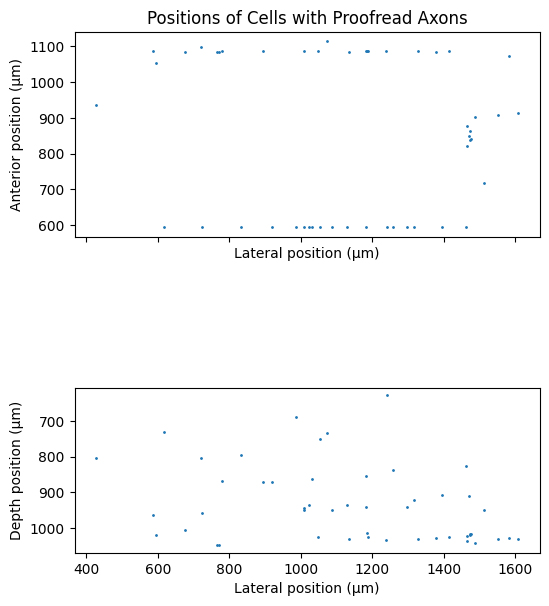

In [109]:
fig,axs = plt.subplots(2,1, figsize=(6,8), sharex=True, gridspec_kw={"height_ratios": [2, 3]})

axs[0].scatter(taxon_df.pt_position_x.values,
                taxon_df.pt_position_z.values,
                s=1)
axs[1].scatter(taxon_df.pt_position_x.values,
                taxon_df.pt_position_y.values,
                s=1)

axs[0].set_aspect("equal")
axs[0].set_xlabel("Lateral position (μm)")
axs[0].set_ylabel("Anterior position (μm)")
axs[0].set_title("Positions of Cells with Proofread Axons")

axs[1].invert_yaxis()
axs[1].set_aspect("equal")
axs[1].set_xlabel("Lateral position (μm)")
axs[1].set_ylabel("Depth position (μm)")